# Forecasting for variable: power_transport_vehicles

The objective of this notebook is to create a model that is able to forecast the values of the above mentioned variable. To do so, we will obatin the data for the entire period (2022-07-01 to 2023-09-19) and divide it between training data (2022-07-01 to 2023-06-30) and test data (2023-07-01 to 2023-09-19).

After dividing the datset, we will perform an analysis on the time series and apply the apporpiate ARIMA or SARIMA model that best works for forecasting.

Finally, we will create and save a model that is able to predict the values for the next day (one per hour of the next day).

In [1]:
import pandas as pd

In [2]:
cd ..

c:\Users\Usuario\OneDrive\Documents\IE\3. Trimestre\Venture Lab & Capstone\Capstone\Tech side\vl_optimizer


## Get the data

In [3]:
input_path = 'data/synthesized_data/production_synthesized.csv'
df = pd.read_csv(input_path)

In [4]:
input_column = 'power_transport_vehicles'
entire_data = df[input_column]
entire_data =pd.Series(entire_data)

In [5]:
entire_data

0         9.841900
1        23.030950
2        19.882106
3        14.685432
4         3.907279
           ...    
10685    13.006434
10686    19.908993
10687     3.109464
10688    34.877178
10689    10.624538
Name: power_transport_vehicles, Length: 10690, dtype: float64

## Train-test split

In [6]:
from datetime import datetime

# Define the dates
train_start_date = datetime(2022, 7, 1)
train_end_date = datetime(2023, 7, 1) # as we include the 30th of July completely

# Calculate the difference
difference_days = train_end_date - train_start_date

# Calculate the difference in hours
difference_hours = difference_days.total_seconds() / 3600

# Print the differences
print("Difference in days:", difference_days.days)
print("Difference in hours:", difference_hours)

Difference in days: 365
Difference in hours: 8760.0


In [7]:
train_data = entire_data[0:int(difference_hours)+1]
test_data = entire_data[int(difference_hours)+1:]

## Defining the model

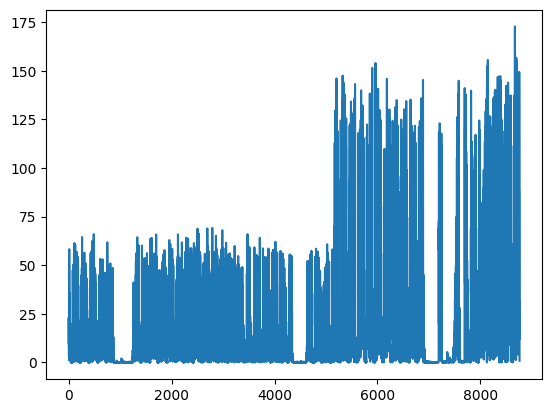

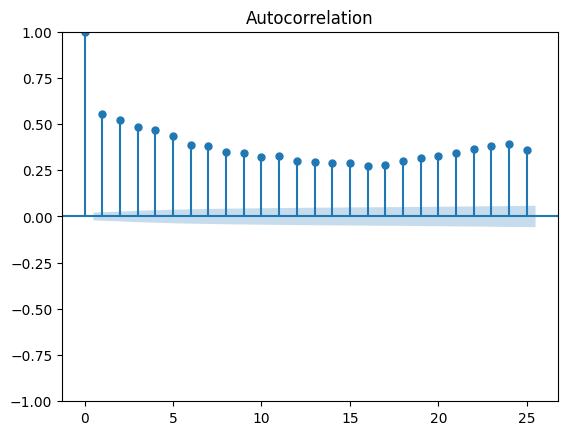

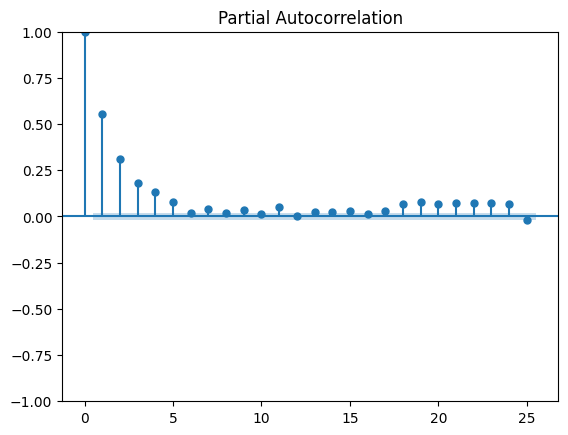

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

y = train_data

n_lags=25 # to discuss

plt.plot(y)
plt.show()
plot_acf(y,lags=n_lags)
plt.show()
plot_pacf(y,lags=n_lags,method="ols")
plt.show()

Data is not stationary so we will see how it works with 1 difference:

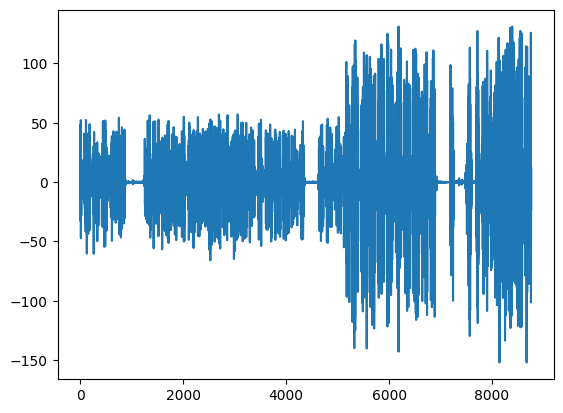

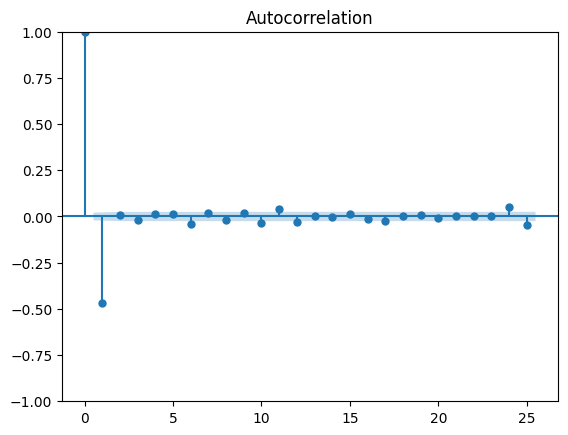

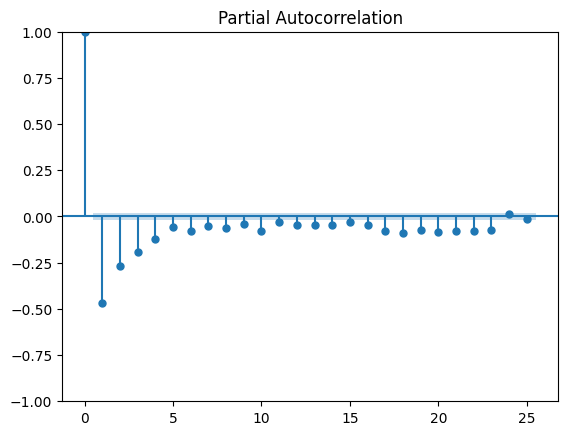

In [13]:
# In case we have to take some differences to the original series
z = y.diff().dropna()
# zz = y.diff(1).diff(1).dropna() # in case we need two differences
plt.plot(z)
plt.show()
plot_acf(z,lags=n_lags)
plt.show()
plot_pacf(z,lags=n_lags)
plt.show()

In [14]:
adf_test = sm.tsa.stattools.adfuller(z,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test after taking one difference")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])

ADF test after taking one difference
Statistic Value: -39.998979741033885
p-value: 0.0


We can now see that based on the ADF test that the data is stationary. 

The next step is to include an AR(1) based on what we see on the Autocorrelation:

                                  SARIMAX Results                                   
Dep. Variable:     power_transport_vehicles   No. Observations:                 8761
Model:                       ARIMA(1, 1, 0)   Log Likelihood              -40581.340
Date:                      Sat, 06 Jul 2024   AIC                          81166.681
Time:                              14:22:29   BIC                          81180.837
Sample:                                   0   HQIC                         81171.504
                                     - 8761                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4665      0.006    -77.083      0.000      -0.478      -0.455
sigma2       618.5203      5.214    118.625      0.000     608.301     628.740
Ljun

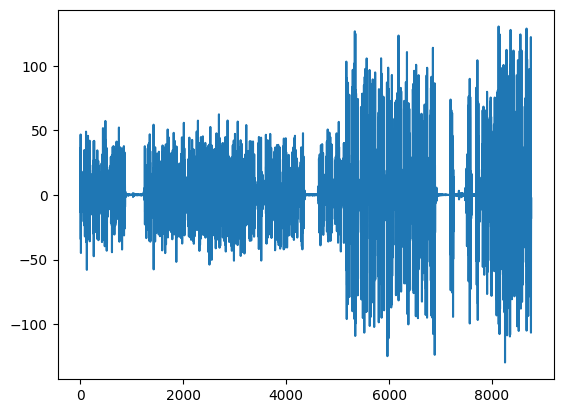

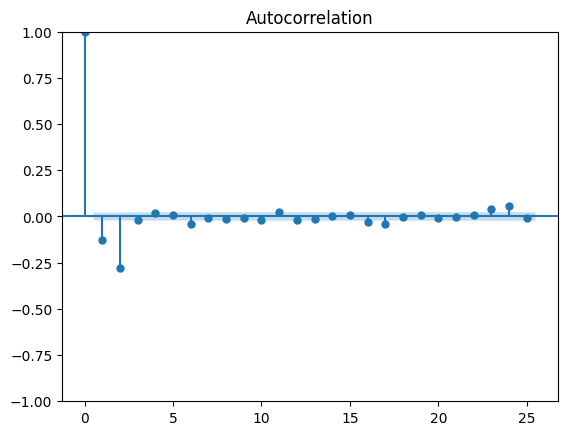

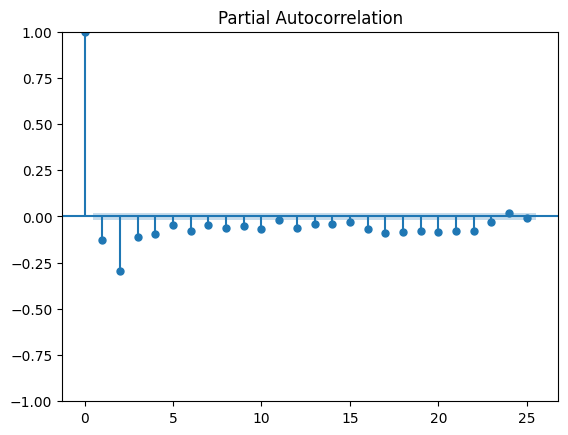

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fit = ARIMA(y, order=(1,1,0))
fit_fit = fit.fit()
print(fit_fit.summary())


residuos=fit_fit.resid

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = n_lags)
plt.show()
plot_pacf(residuos, lags = n_lags,method="ols")
plt.show()

We see that there is still some difference on the PACF so we try with including an MA(2)

                                  SARIMAX Results                                   
Dep. Variable:     power_transport_vehicles   No. Observations:                 8761
Model:                       ARIMA(1, 1, 2)   Log Likelihood              -39935.328
Date:                      Sat, 06 Jul 2024   AIC                          79878.656
Time:                              14:22:31   BIC                          79906.968
Sample:                                   0   HQIC                         79888.303
                                     - 8761                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8929      0.060    -14.931      0.000      -1.010      -0.776
ma.L1          0.1717      0.058      2.947      0.003       0.058       0.286
ma.L

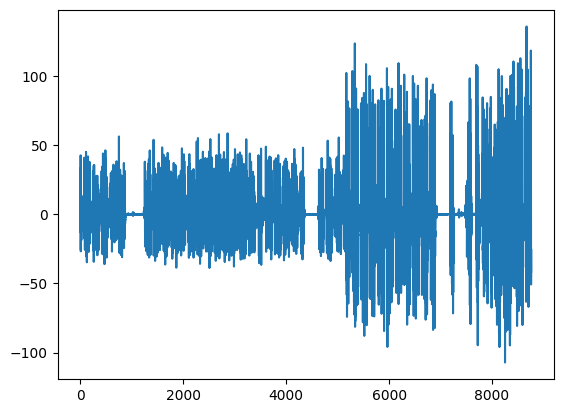

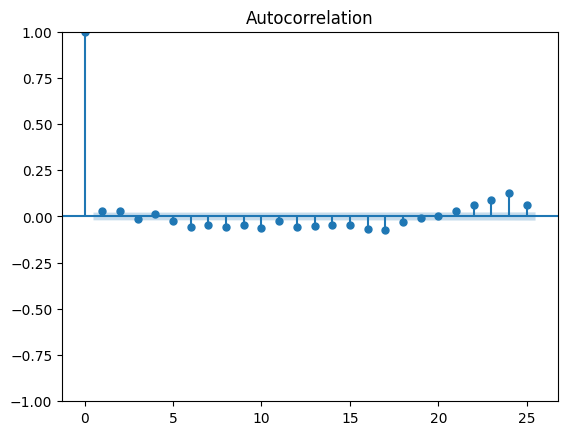

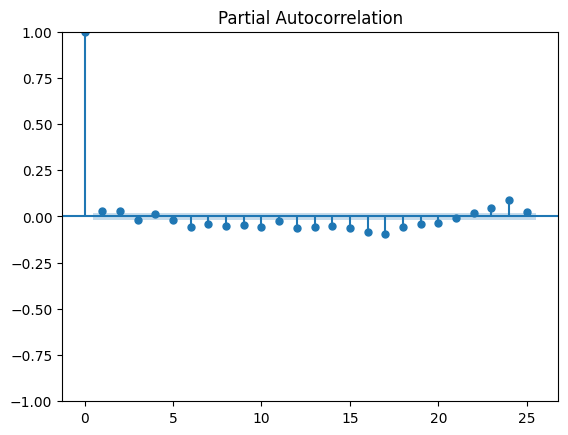

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fit = ARIMA(y, order=(1,1,2))
fit_fit = fit.fit()
print(fit_fit.summary())


residuos=fit_fit.resid

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = n_lags)
plt.show()
plot_pacf(residuos, lags = n_lags,method="ols")
plt.show()

Let's try the box test to test the model:

Ljung-Box
       lb_stat      lb_pvalue
25  626.359187  3.710433e-116
Shapido: Statistic value 0.9067468047142029 p-value 0.0


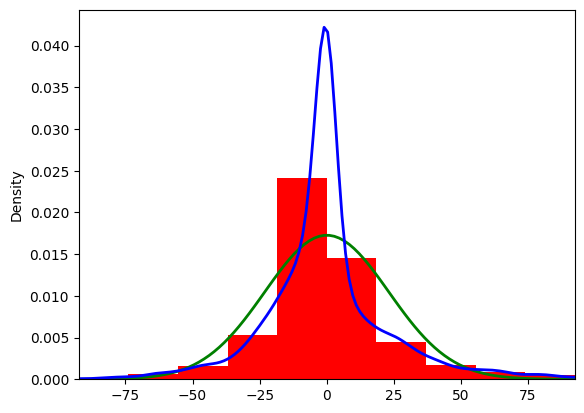

In [17]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

The data is correlated so let's try to take into account seasonality:

                                  SARIMAX Results                                   
Dep. Variable:     power_transport_vehicles   No. Observations:                 8761
Model:                 SARIMAX(0, 1, 0, 24)   Log Likelihood              -42890.461
Date:                      Sat, 06 Jul 2024   AIC                          85782.923
Time:                              14:22:33   BIC                          85789.998
Sample:                                   0   HQIC                         85785.334
                                     - 8761                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1075.1853      9.830    109.378      0.000    1055.919    1094.452
Ljung-Box (L1) (Q):                 809.10   Jarque-Bera (JB):              4403.56

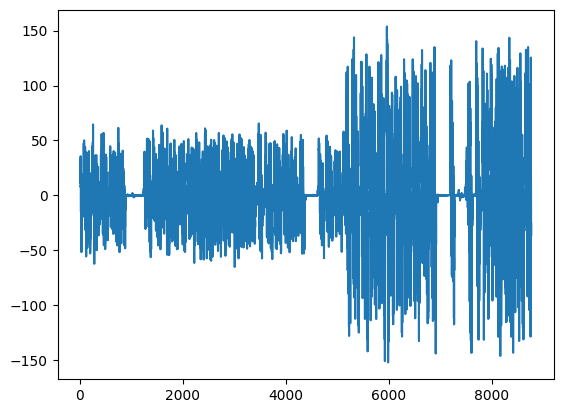

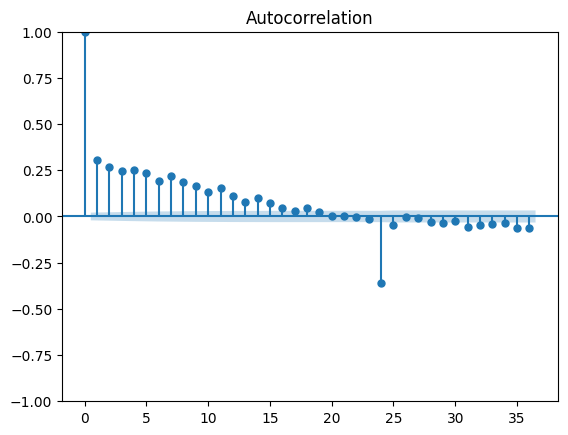

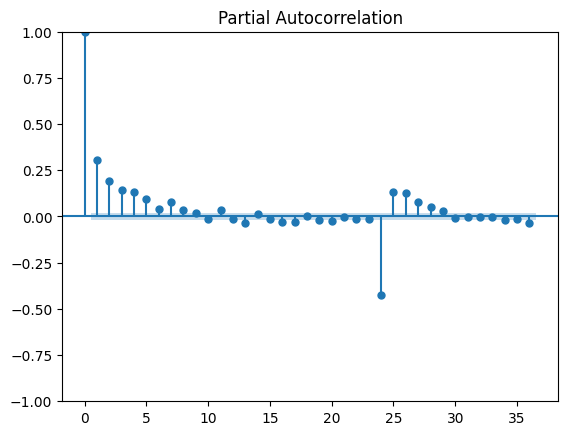

In [18]:
s = 24

fit = SARIMAX(endog = y, order = (0,0,0), seasonal_order = (0,1,0,s)).fit()
print(fit.summary())
residuos = fit.resid[13:]

nlags=36

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

After different trials:

                                       SARIMAX Results                                       
Dep. Variable:              power_transport_vehicles   No. Observations:                 8761
Model:             SARIMAX(0, 1, 23)x(0, 0, [1], 24)   Log Likelihood              -39714.483
Date:                               Sat, 06 Jul 2024   AIC                          79478.966
Time:                                       14:24:15   BIC                          79655.914
Sample:                                            0   HQIC                         79539.258
                                              - 8761                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7360      0.007   -111.318      0.000      -0.749      -0.723
ma.L2      

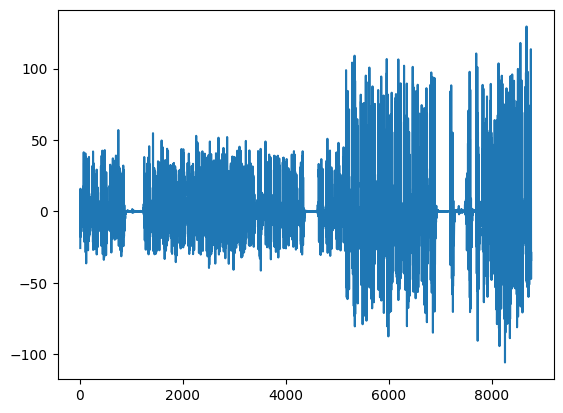

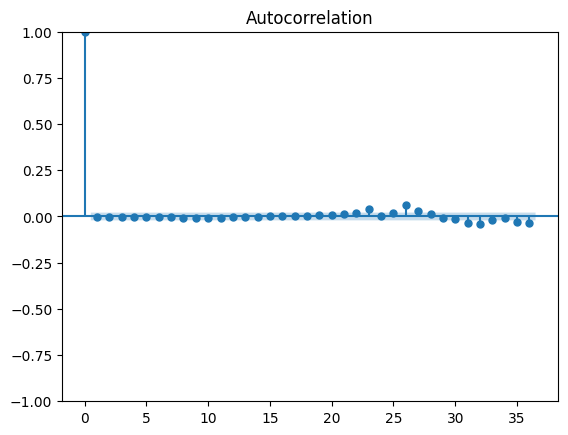

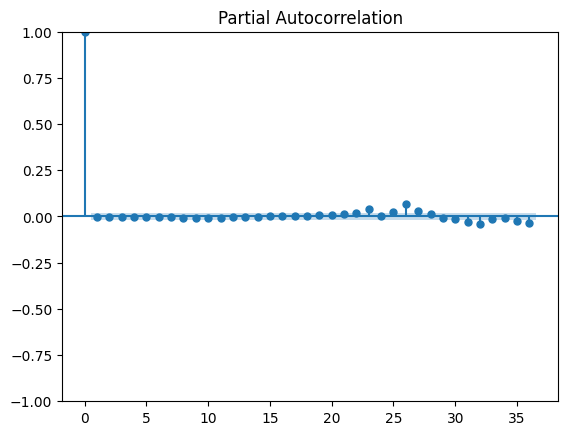

In [19]:
s = 24

fit = SARIMAX(endog = y, order = (0,1,23), seasonal_order = (0,0,1,s)).fit()
print(fit.summary())
residuos = fit.resid[13:]

nlags=36

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

Ljung-Box
      lb_stat  lb_pvalue
25  25.977364   0.408807
Shapido: Statistic value 0.9060171842575073 p-value 0.0


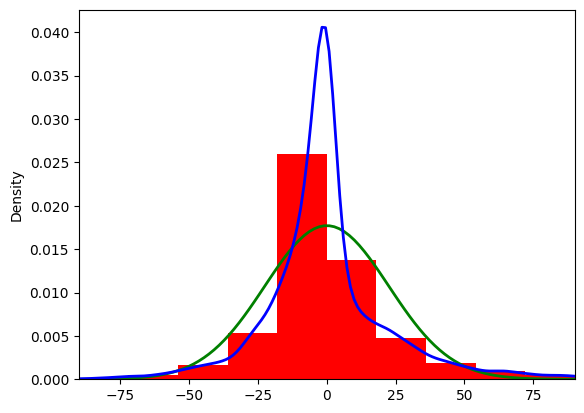

In [20]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

## Try and Save the model

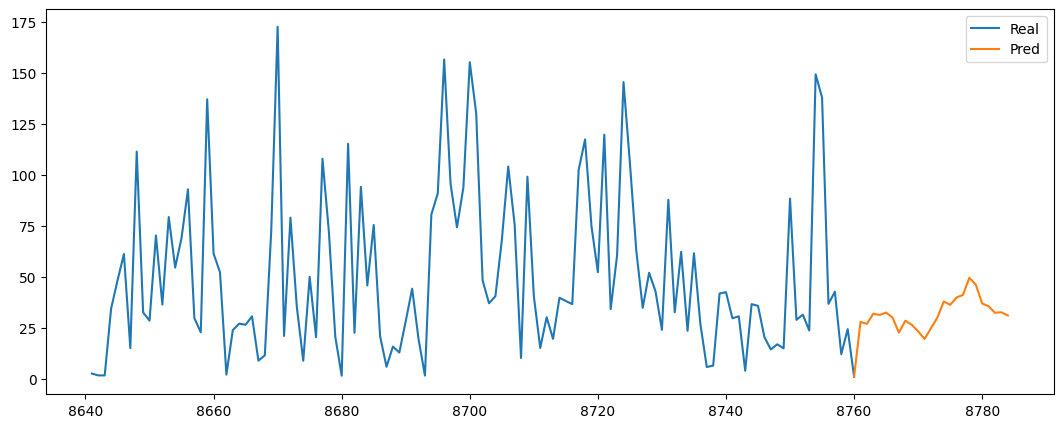

In [21]:
# Prepare the next 24 steps
y_pred = fit.forecast(steps = 24)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y[-120:], label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

In [23]:
import joblib
import os

# Define the directory and file name
directory = 'forecasting/forecasters'
file_name = input_column
file_path = directory + '/' + file_name + '.joblib'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the model to the specified directory
joblib.dump(fit, file_path)

print(f"Model saved successfully at {file_path}")

Model saved successfully at forecasting/forecasters/power_transport_vehicles.joblib
